# Albert fine-tuned with Ag_News_Subset Colab

This notebook load a pre-trained albert model from tf hub and run fine-tuning with ag_news_subset from tfds.

In [1]:
import os
import time
import datetime
import pandas as pd
from tensorflow import keras
import pickle
import json
import re
import keras
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Mon Mar  1 19:48:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    37W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install and import Tensrflow Modules

Import TensorFlow and Tensorflow Hub

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
print(tf.version.VERSION)

2.4.1


Install TensorFLow Official Models

In [4]:
# pip install tf-models-official

## Ag_News_Subset Dataset

### Download dataset from TFDS

Download the dataset from TFDS and split into train/dev/test or train/test.

In [5]:
import tensorflow_datasets as tfds

# (train_data, test_data, dev_data), info = tfds.load('ag_news_subset',
#                                                      split=['train[:83%]', 'train[83%:]', 'test[:100%]'],
#                                                      as_supervised=True,
#                                                      with_info=True
#                                                      )

(train_data, test_data), info = tfds.load('ag_news_subset',
                                          split=['train[:100%]', 'test[:100%]'],
                                          as_supervised=False,
                                          with_info=True
                                          )

### Dataset Preprocessing

Convert Tensors to Pandas Dataframe

In [6]:
df_train = tfds.as_dataframe(train_data, info)
df_test = tfds.as_dataframe(test_data, info)

Dataset Shapes and Labels Balancement

In [7]:
df_train.shape

(120000, 3)

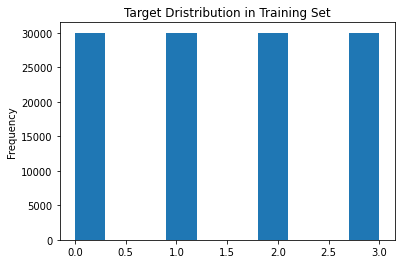

In [8]:
df_train.label.plot(kind='hist', title='Target Dristribution in Training Set')

In [9]:
df_test.shape

(7600, 3)

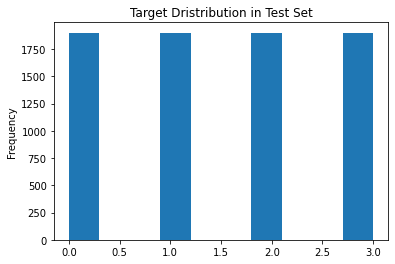

In [10]:
df_test.label.plot(kind='hist', title='Target Dristribution in Test Set')

Decode `description` and `title` columns from Train and Test datasets

In [11]:
df_train['description'] = df_train['description'].str.decode('utf8')
df_train['title'] = df_train['title'].str.decode('utf8')

df_test['description'] = df_test['description'].str.decode('utf8')
df_test['title'] = df_test['title'].str.decode('utf8')

Concatenate `description` and `title` columns into a new column named `text` from Train and Test datasets

In [12]:
df_train['text'] = df_train['title'] + '. ' + df_train['description']
df_test['text'] = df_test['title'] + '. ' + df_test['description']

Add a new column named `id` as identifier of the input text

In [13]:
df_train['id'] = range(0, len(df_train))
df_test['id'] = range(len(df_train),len(df_train)+len(df_test) )

Select columns `id`, `text` and `label`

In [14]:
df_train = df_train[["id","text","label"]]
df_test = df_test[["id","text","label"]]

Visualize first rows of the dataframe

In [15]:
df_train.head(5)

,id,text,label
0,0,AMD Debuts Dual-Core Opteron Processor. AMD #3...,3
1,1,Wood's Suspension Upheld (Reuters). Reuters - ...,1
2,2,Bush reform may have blue states seeing red. P...,2
3,3,'Halt science decline in schools'. Britain wil...,3
4,4,"Gerrard leaves practice. London, England (Spor...",1


In [16]:
df_test.head(5)

,id,text,label
0,120000,Carolina's Davis Done for the Season. CHARLOT...,1
1,120001,"Philippine Rebels Free Troops, Talks in Doubt....",0
2,120002,New Rainbow Six Franchise for Spring 2005. SAN...,3
3,120003,Kiwis heading for big win. DANIEL VETTORI spun...,1
4,120004,"Shelling, shooting resumes in breakaway Georgi...",0


Create a new dataframe as copy of the original datasets

In [17]:
df_train_cleaned = df_train.copy()
df_test_cleaned = df_test.copy()

Define a cleaning function to be applied to each input text

In [18]:
def clean_text(text):
  text = re.sub("@\S+", " ", text) # Remove Mentions
  text = re.sub("https*\S+", " ", text) # Remove URL
  text = re.sub("#\S+", " ", text) # Remove Hastags
  text = re.sub('&lt;/?[a-z]+&gt;', '', text) # Remove special Charaters
  text = re.sub('#39', ' ', text) # Remove special Charaters
  text = re.sub('<.*?>', '', text) # Remove html
  text = re.sub(' +', ' ', text) # Merge multiple blank spaces
  return text

Clean the `text` column of the dataframe with the `cleaning_text` funcion defined before

In [19]:
df_train_cleaned["text"] = df_train_cleaned["text"].apply(clean_text)
df_test_cleaned["text" ]= df_test_cleaned["text"].apply(clean_text)

In [20]:
df_train_cleaned.head(5)

,id,text,label
0,0,AMD Debuts Dual-Core Opteron Processor. AMD ne...,3
1,1,Wood's Suspension Upheld (Reuters). Reuters - ...,1
2,2,Bush reform may have blue states seeing red. P...,2
3,3,'Halt science decline in schools'. Britain wil...,3
4,4,"Gerrard leaves practice. London, England (Spor...",1


Save the original dataset and the cleaned dataset

In [21]:
FINE_TUNING_DIR = "/content/drive/MyDrive/saved_models/fine_tuned/ebano_albert_ag_news_subset"

DATASET_DIR = os.path.join(FINE_TUNING_DIR, "dataset")
MODEL_DIR = os.path.join(FINE_TUNING_DIR, "model")

In [22]:
mkdir '$FINE_TUNING_DIR'

mkdir: cannot create directory ‘/content/drive/MyDrive/saved_models/fine_tuned/ebano_albert_ag_news_subset’: File exists


In [23]:
mkdir '$DATASET_DIR'

mkdir: cannot create directory ‘/content/drive/MyDrive/saved_models/fine_tuned/ebano_albert_ag_news_subset/dataset’: File exists


In [24]:
mkdir '$MODEL_DIR'

mkdir: cannot create directory ‘/content/drive/MyDrive/saved_models/fine_tuned/ebano_albert_ag_news_subset/model’: File exists


In [25]:
df_train.to_csv(os.path.join(DATASET_DIR,"df_train_original.csv"))
df_test.to_csv(os.path.join(DATASET_DIR,"df_test_original.csv"))

df_train_cleaned.to_csv(os.path.join(DATASET_DIR,"df_train_cleaned_.csv"))
df_test_cleaned.to_csv(os.path.join(DATASET_DIR,"df_test_cleaned.csv"))

Convert train and test dataframe into tensors

In [26]:
train_data = tf.data.Dataset.from_tensor_slices((df_train_cleaned.text, df_train_cleaned.label))
test_data = tf.data.Dataset.from_tensor_slices((df_test_cleaned.text, df_test_cleaned.label))

In [27]:
del df_train
del df_test
del df_train_cleaned
del df_test_cleaned

## AlbertModel Class

In [28]:
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization

class AlbertModel:
  def __init__(self):

    self.pretrained_albert_layer = None
    self.sp_model_file = None
    self.tokenizer = None
    self.num_classes = None
    self.max_seq_length = None
    self.label_list = None
    self.TF_HUB_URL = "https://tfhub.dev/tensorflow/albert_en_base/2"


    self.info_dict = {}
    return

  def load_pretrained_albert_tf_hub_from_url(self, url=None, trainable_flag=True):
    if url is None:
      url = self.TF_HUB_URL
    self.pretrained_albert_layer = hub.KerasLayer(url, trainable=trainable_flag)
    self.pretrained_albert_layer._name = "albert_layer"
    
    self.info_dict.update({"trained_albert_weights":trainable_flag})
    return

  def load_pretrained_albert_tf_hub_from_dir(self, tf_hub_model_dir):
    self.pretrained_albert_layer = hub.KerasLayer(tf_hub_model_dir, trainable=trainable_flag)
    self.pretrained_albert_layer._name = "albert_layer"

    self.info_dict.update({"trained_albert_weights":trainable_flag})
    return

  
  def load_model(self, model_directory):
    # Load Tokenizer 
    with open(os.path.join(model_directory, "albert_tokenizer.pickle"), "rb") as tokenizer_file:
        self.tokenizer = pickle.load(tokenizer_file)

    # Load Model
    self.model = keras.models.load_model(model_directory)

    # Read from metadata file the max_seq_length
    with open(os.path.join(model_directory, "metadata", "experimenti_info.json"), "rb") as metadata_file:
      self.info_dict = json.load(metadata_file)
      self.max_seq_length = self.info_dict["max_seq_length"]

    # Load the feature extractor (albert layer)
    self.extractor = tf.keras.Model(inputs=self.model.inputs,
                                    outputs=[self.model.get_layer("albert_layer").output])

    print("INFO: model loaded")
    self.model.summary()
    print("INFO: features extractor loaded")
    self.extractor.summary()
    return


  def create_model(self, num_classes, label_list, label_names=None, dropout_percentage=0.2, max_seq_length=256):

    self.num_classes = num_classes
    self.max_seq_length = max_seq_length
    self.label_list = label_list

    if self.num_classes > 2:
      activation_function = "softmax"
    else:
      activation_function = "sigmoid"

    # Save parameters setting
    self.info_dict.update({"num_classes":num_classes, "label_list":label_list, "label_names":label_names, 
                           "dropout_percentage":dropout_percentage, "max_seq_length":max_seq_length, "output_activation":activation_function})


    # Define Albert inputs
    input_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                          name="input_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="segment_ids")
    
    albert_inputs = dict(input_word_ids=input_ids,
                      input_mask=input_mask,
                      input_type_ids=segment_ids)
    
    # Define Albert block
    albert_outputs = self.pretrained_albert_layer(albert_inputs)

    self.sp_model_file = self.pretrained_albert_layer.resolved_object.sp_model_file.asset_path.numpy()
    self.tokenizer = tokenization.FullSentencePieceTokenizer(self.sp_model_file)

    #pooled_output = albert_outputs["pooled_output"]
    #sequence_output = albert_outputs["sequence_output"]

    drop = tf.keras.layers.Dropout(dropout_percentage)(albert_outputs["pooled_output"])

    classification_output = tf.keras.layers.Dense(num_classes, activation=activation_function, name="classification")(drop)

    model = tf.keras.Model(
        inputs=albert_inputs,
        outputs=classification_output
    )

    self.model = model
    
    return

  def fit(self, train_data, test_data, epochs, batch_size, shuffle_batch_size=10000, verbose=1, drop_remainder=False):

    self.info_dict.update({"epochs":epochs, "batch_size":batch_size, "shuffle_batch_size":shuffle_batch_size})

    with tf.device('/cpu:1'):
          # train
          train_data = (train_data.map(self.to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                  .shuffle(shuffle_batch_size)
                                  .batch(batch_size, drop_remainder=drop_remainder)
                                  .prefetch(tf.data.experimental.AUTOTUNE))
          # valid
          test_data = (test_data.map(self.to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                .batch(batch_size, drop_remainder=drop_remainder)
                                .prefetch(tf.data.experimental.AUTOTUNE))

    self.history = self.model.fit(train_data,
                            validation_data=test_data,
                            epochs=epochs,
                            verbose=verbose)
    
    return self.history

  def compile(self, learning_rate=2e-5, loss="Adam", metrics=['accuracy']):
    self.info_dict.update({"learning_rate":learning_rate, "loss":loss.__str__(), "metrics":metrics})

    self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                        loss=loss,
                        metrics=metrics
                        )


    return

  def to_feature(self, text, label):
      example = classifier_data_lib.InputExample(guid=None,
                                                  text_a=text.numpy(),
                                                  text_b=None,
                                                  label=label.numpy())

      feature = classifier_data_lib.convert_single_example(0, example, self.label_list, self.max_seq_length, self.tokenizer)

      return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

  def to_feature_map(self, text, label):
      input_ids, input_mask, segment_ids, label_id = tf.py_function(self.to_feature,
                                                                    inp=[text, label],
                                                                    Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

      input_ids.set_shape([self.max_seq_length])
      input_mask.set_shape([self.max_seq_length])
      segment_ids.set_shape([self.max_seq_length])
      label_id.set_shape([])

      x = {
          'input_word_ids': input_ids,
          'input_mask': input_mask,
          'input_type_ids': segment_ids
      }

      return (x, label_id)

  def save_model(self, folder_name, experiment_description=None):
        if folder_name is None:
            ts = time.time()
            folder_name = datetime.datetime.fromtimestamp(ts).strftime('%Y%m%d_%H%M%S')

        if experiment_description is None:
            out_name = '{}_albert_model'.format(folder_name)
        else:
            out_name = '{}_albert_model_{}'.format(folder_name, experiment_description)

        output_path = os.path.join(folder_name, out_name)
        metadata_path = os.path.join(output_path, "metadata")
        try:
            os.mkdir(output_path)
            os.mkdir(metadata_path)
        except OSError:
            print("Creation of the output directory %s failed" % output_path)

        # convert the history.history dict to a pandas DataFrame:
        hist_df = pd.DataFrame(self.history.history)

        # save to json:
        hist_json_file = '{}_history.json'.format(folder_name)
        hist_json_fie_path = os.path.join(metadata_path, hist_json_file)
        with open(hist_json_fie_path, mode='w+') as f:
            hist_df.to_json(f)

        self.model.save(output_path)

        with open(os.path.join(output_path, 'albert_tokenizer.pickle'), 'wb') as handle:
            pickle.dump(self.tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(os.path.join(output_path, 'metadata', 'experiment_info.json'), 'w') as fp:
            json.dump(self.info_dict, fp)

        print("INFO: Model saved in path: ", output_path)
        return output_path


  def summary(self):
    self.model.summary()
    return

  def get_model(self):
    return self.model

  def get_tokenizer(self):
    return self.tokenizer




## Create an instance of AlbertModel

Define TF_HUB_URL and TF_HUB_DIR 


In [29]:
TF_HUB_DIR = "/content/drive/MyDrive/saved_models/pre_trained/albert_base/albert_en_base_2"
TF_HUB_URL = "https://tfhub.dev/tensorflow/albert_en_base/2"

### Optional: Download TF_HUB_MODULE

Uncomment these lines if want to download and tar the TF Hub Module on local drive.

In [30]:
# !wget "https://storage.googleapis.com/tfhub-modules/tensorflow/albert_en_base/2.tar.gz"

In [31]:
# mkdir '$TF_HUB_DIR'

In [32]:
# !tar -xvf  '2.tar.gz' -C '$TF_HUB_DIR'


### Define, Create and Load Model

Define model parameters and settings

In [33]:
LABEL_LIST = [0,1,2,3]
LABEL_NAMES = ["World", "Sport", "Business", "Sci/Tech"]
NUM_CLASSES = len(LABEL_LIST)
max_seq_length = 128
activation_function = "softmax"
learning_rate = 1e-5
dropout_perc = 0.25

Create and instance of the AlbertModel Class

In [34]:
albert_model = AlbertModel()

Optional: Load tf_hub_module from local drive (only if previously have downloaded and unzipped in local drive).

In [35]:
# albert_model.load_pretrained_albert_tf_hub_from_dir(TF_HUB_DIR)

Load TF_HUB_MODULE from URL

In [36]:
albert_model.load_pretrained_albert_tf_hub_from_url(TF_HUB_URL)

Create the full model and print the summary

In [37]:
albert_model.create_model(num_classes=NUM_CLASSES, label_list=LABEL_LIST, label_names=LABEL_NAMES, dropout_percentage=dropout_percentage, max_seq_length=max_seq_length)
albert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 256)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
albert_layer (KerasLayer)       {'pooled_output': (N 11683584    input_mask[0][0]                 
                                                                 segment_ids[0][0]            

## Training

### Compile the model
Compile the model with sparse_categorical_crossentropy loss and Adam optimizer

In [38]:
albert_model.compile(learning_rate=learning_rate, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Define trainig parameters

In [39]:
EPOCHS = 3
BATCH_SIZE = 16

### Run training
Train the model

In [40]:
history = albert_model.fit(train_data, test_data, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/3
7500/7500 [==============================] - 4584s 609ms/step - loss: 0.3986 - accuracy: 0.8642 - val_loss: 0.2919 - val_accuracy: 0.8978
Epoch 2/3
7500/7500 [==============================] - 4575s 609ms/step - loss: 0.2455 - accuracy: 0.9152 - val_loss: 0.3051 - val_accuracy: 0.8970
Epoch 3/3
7500/7500 [==============================] - 4574s 609ms/step - loss: 0.2348 - accuracy: 0.9197 - val_loss: 0.2351 - val_accuracy: 0.9203


### Plot loss and accuracy

Define plot_history function

In [41]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1,len(acc) +1)

  plt.plot(epochs,acc, 'bo' , label="Training acc")
  plt.plot(epochs,val_acc, 'b' , label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.legend()

  plt.figure()

  plt.plot(epochs,loss, 'bo' , label="Training loss")
  plt.plot(epochs,val_loss, 'b' , label="Validation loss")
  plt.title("Training and validation loss")
  plt.legend()

  plt.show()
  return

Plot accuracy and loss

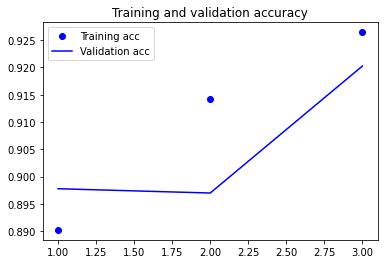

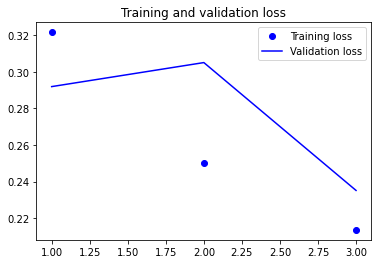

In [42]:
plot_history(history)

## Save Model

In [43]:
albert_model.save_model(MODEL_DIR)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_models/fine_tuned/ebano_albert_ag_news_subset/model_albert_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_models/fine_tuned/ebano_albert_ag_news_subset/model_albert_model/assets


INFO: Model saved in path:  /content/drive/MyDrive/saved_models/fine_tuned/ebano_albert_ag_news_subset/model_albert_model


'/content/drive/MyDrive/saved_models/fine_tuned/ebano_albert_ag_news_subset/model_albert_model'